In [1]:
import pandas as pd
df = pd.read_csv('./citibike_2023_cleaned.csv')

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score

#split the dataset into features and labels
features = df.drop(columns=['trip_duration'])
target = df['trip_duration']

#split the data into development (80%) and test datasets (20%)
x_dev, x_test, y_dev, y_test = train_test_split(features, target, test_size=0.2)

In [3]:
!pip install category_encoders

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import numpy as np

#define which columns will have which transformations
oh_features = ['rideable_type', 'member_casual']
ord_features = ['start_station_name', 'end_station_name']

#define transformations
one_h = OneHotEncoder(handle_unknown='ignore')
ord_e = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocess = ColumnTransformer(transformers = [('onehot', one_h, oh_features),
                                               ('ordinal', ord_e, ord_features)], remainder = 'passthrough')
pipeline = Pipeline(steps=[('prep',preprocess)])

#apply encoding
x_dev_enc = pipeline.fit_transform(x_dev)
x_test_enc = pipeline.transform(x_test)

onehot_features = pipeline.named_steps['prep'].transformers_[0][1].get_feature_names_out(oh_features)
# Combine feature names
all_features = np.concatenate([onehot_features, x_dev.drop(columns=oh_features + ord_features).columns, ord_features])

# Create DataFrames
x_dev_encoded = pd.DataFrame(x_dev_enc, columns=all_features, index=x_dev.index)
x_test_encoded = pd.DataFrame(x_test_enc, columns=all_features, index=x_test.index)

<Axes: >

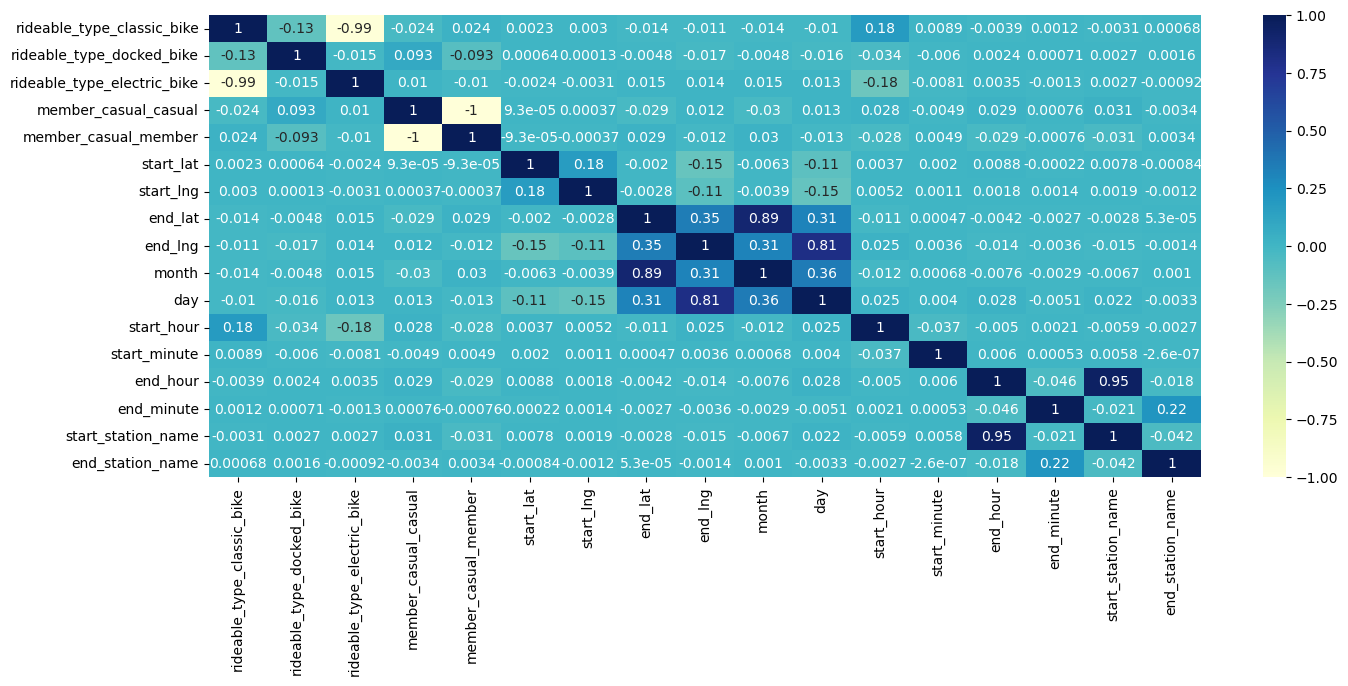

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (16,6))
sns.heatmap(x_dev_encoded.corr(), cmap="YlGnBu", annot=True)

In [21]:
def get_report(y_pred, y_test):
    """
    Report the first 3 and last 3 predictions on X_test,
    along with the actual labels in y_test.

    Returns:
        A dataframe with 6 rows comparing predictions and actuals.
    """
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual': actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

In [22]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()

regr.fit(x_dev_encoded, y_dev)

# Make predictions using the testing set
y_pred = regr.predict(x_test_encoded)

dev_y_pred= regr.predict(x_dev_encoded)
dev_r2_score = r2_score(y_dev, dev_y_pred)

test_y_pred = regr.predict(x_test_encoded)
test_r2_score = r2_score(y_test, test_y_pred)

print(f"R^2 Score on Development set: {dev_r2_score:.4f}")
print(f"R^2 Score on Test set: {test_r2_score:.4f}")

R^2 Score on Development set: 0.0132
R^2 Score on Test set: 0.0148


In [23]:
get_report(test_y_pred, y_test)

,Prediction,Actual
Position,,
1,12.937736,9.150000
2,12.205792,5.250000
3,10.942606,7.666667
199998,22.357632,8.450000
199999,10.928621,0.166667
200000,14.524982,14.633333
